In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

import warnings
warnings.filterwarnings("ignore")

In [25]:
# Getting the data
customer_data_df = pd.read_csv("../Data/pre_processed_data_1.csv", sep = "\t")
customer_data_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


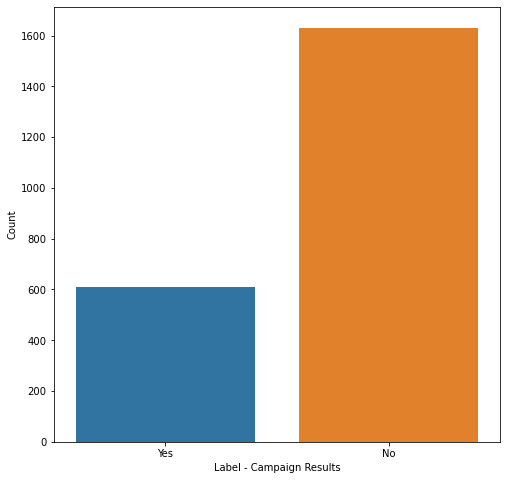

In [13]:
# Distribution of the labels in the dataset
plt.rcParams["figure.figsize"] = (8, 8)
sns.countplot(customer_data_df["AcceptedAnyCmp"])
plt.grid(False)
plt.xlabel("Label - Campaign Results")
plt.ylabel("Count")
plt.show()

In [14]:
# Splitting the dataset
data_X = customer_data_df.drop(columns=['AcceptedAnyCmp'])
data_y = customer_data_df['AcceptedAnyCmp']
print(data_X.columns)

Index(['ID', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Age', 'IfSingle', 'EnrollDays', 'Expenses',
       'NumPurchases', 'NumAcceptedCmp'],
      dtype='object')


In [17]:
# Dropping more columns that we are not going to use
data_X.drop(columns = ['ID'], inplace = True)

In [19]:
# Pre-Processing the data

In [21]:
# Encoding the labels in the dataset
label_types = list(set(data_y))
ord_encoder = OrdinalEncoder(categories = [label_types])
enc_labels = ord_encoder.fit_transform(data_y.to_numpy().reshape(-1, 1))
print(f"The shape of the labels data is: {enc_labels.shape}")

The shape of the labels data is: (2240, 1)


array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]])